# Predicting breakthrough biotech patents with machine learning models

<i>This notebook builds on my individual contribution to the working paper "Some Inventions are More Equal than Others: Assessing and Developing Patent Indicators that Signal Radical Inventions", joint work with Paul-Emmanuel Anckaert, Francesco Appio, Cindy Lopes-Bento, Bart Van Looy and Dennis Verhoeven (from KU Leuven, the Pôle Universitaire Léonard de Vinci and Maastricht University). My role in this project was developing, improving and testing the predictive machine learning models. All the contributions from my colleagues are greatly appreciated. </i>

### 1. Introduction
<b> The importance of breakthroughs.</b> Early and accurate prediction of patents with high value and technological impact, often called *breakthrough patents*, has considerable strategic, commercial and financial importance for firms. On the one hand, R&D-performing firms that develop novel technologies need accurate predictions of the value and potential of R&D pipelines in order to conduct efficient technology management. On the other hand, downstream firms that acquire or license technologies and patents from external partners need ever more accurate predictions about the potential of those patents. Moreover, because investing in the right technology can help firms build a competitive advantage and a solid market position, early prediction of technological breakthroughs is of strategic importance in nascent markets and sectors (e.g., biotechnology in the 1980s or carbon nanotubes in 2010s). Additionally, firms keep patents *alive* by paying hefty renewal fees, and accurate prediction of breakthroughs can help improve their patent portfolio strategies based on real evidence. However, patents vary greatly in terms of value and technological importance. In fact, the vast majority of patents are worthless while breakthroughs are few, infrequent and very difficult to predict. 

This notebook presents a supervised learning task. In it, I build predictive machine learning models for breakthrough patents and train/validate them using patent data from the early stage of the biotechnology sector---between 1986 and 2001.

<b> Approach, models and data.</b> In all models an instance is a biotech patent, a binary target indicates whether the patent is biotech breakthrough and model features are patent-based indicators (i.e., indicators and metrics built using patent data). The baseline model is a logistic classifier (LC) which includes the typical features present in studies of technological breakthroughs (both the model and the features are the prevalent approach in these kind of studies, e.g., Arts et al. 2013). I extend the baseline model in three consecutive steps:
1.  Adding to the model new patent-based features that characterize a patent's technological novelty. 
1.  Recalculating features using a correction based on the INPADOC patent family definition. 
1.  Training a random forests classifier (RFC) on the family-corrected features. 

The first step is motivated by recent scientific literature showing that technological novelty is a powerful predictor of breakthroughs (e.g., Verhoeven et al. 2016). The second step is motivated by: a) scientific literature showing that meta-data from patent families (legally speaking, a group of patents linked by priority claims) can help increase target and feature accuracy (e.g., Harhoff et al. 2003, Bakker et al. 2015)<!---Harhoff, Scherer, and Vopel, 2003 -->; and b) the existence of different definitions and operationalizations of "patent family." Finally, the third step is motivated by the flexibility of RFCs and their potential for reducing overfitting. All models are trained using a dataset composed by 82,546 patents applied between 1986 and 2001, which amount to all the biotech patents granted by the US Patent and Trademark Office (USPTO) and applied during that period. 

<b> Results.</b> Less than 0.05% of patents in the dataset are breakthroughs. As expected, breakthroughs are extremely rare and the target vector is highly unbalanced. Hence, to measure models' predictive power I compare recall, precision and AUC scores, rather than accuracy. The recall, precision and AUC scores of the baseline model (LC with the *existing ex-ante* features only) are 0.17, 0.87 and 0.59, respectively. All other models outperform the baseline, to different degrees. To ilustrate this, Figure 1 benchmarks scores from the best-performing model (the RFC with all the *novelty* features and the INPADOC correction) against the baseline model's. The figure reveals that the largest gains are obtained with respect to recall and average precision. Indeed, the RFC improves recall, precision, average precision and AUC with respect to the baseline LC model by 405%, 15%, 93% and 147%, respectively.

In [6]:
%run -i "predicting_biotech_bt_ML.py"

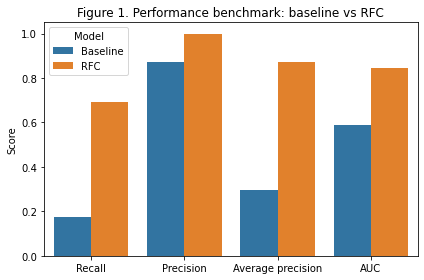

In [7]:
benchmark_plot()

### 2. Data, target and features
<b>Patent data and patent-based indicators.</b> Patent documents are a rich source of invention data and meta-data that can be used to build patent-based indicators (e.g., patent claims, technological principles and components, but also co-inventors, applicant firms, application date, prior art, etc.).  In a broad sense, there are two types of patent-based indicators: ex-ante and ex-post indicators. Ex-ante indicators are built with data available up to moment of the patent application (e.g., inventor names, citations made by the patent to prior art, etc.). By contrast, ex-post indicators use data which is generated and/or available only after the patent application (e.g., citations received by the patent after its publication by the patent office, commercial performance of the patented invention, licensing revenue, etc.).

Ex-post indicators, such as citations received, are strongly correlated with patent value and impact. However, such indicators can only be computed many years after the patent application, so, by definition, they cannot be used as early predictors of breakthroughs. In line with the goal of this notebook, models are trained using only ex-ante indicators.

<b>Data.</b> The dataset consists of all biotechnology patents (following the OECD 2006 definition) granted by the USPTO, and applied between 1985 and 2001 (n=82,546). All patent data was sourced from Patstat v2018-Autumn.

<b>Target.</b> Target labels are taken from Arts et al. (2013), who identified the most important biotech inventions and mapped them to their respective patents. The target, *important*, equals 1 if the patent is an important biotech invention and 0 otherwise.

<b>Features.</b> Models use three types of features: control, *existing* ex-ante and *new* ex-ante features. The features of each type are:
-  Controls: counts of distinct IPC4 and IPC6 classes (i.e., 4- and 6-digit International Patent Classification classes), claims, backward citations, non-patent citations, inventors and applicants. Further controls are features for each IPC4 technology class and one-hot dummies for application years.
-  Existing ex-ante: Originality (Trajtenberg et al. 1997) computed at IPC4 and IPC6 levels; Radicalness (Shane 2001) computed at IPC3, IPC4 and IPC6 levels.
-  New ex-ante: <i>New technological origins</i> (NTO), <i>New functionality</i> (NF) and <i>New scientific origins</i> (NSO) (see Verhoeven et al. 2016 for definitions and details on how to construct these features). Each feature measures a different dimension of technological novelty and is calculated with different degrees of granularity, using either IPC4 or IPC6 classes. Each feature takes integer values, where a greater value represents a greater score in the respective dimension.

<b>Patent families.</b> There are different definitions of patent family, and this notebook uses two of them: DOCDB and INPADOC. The DOCDB definition is useful for finding 'equivalent' patents: this is the case when the same patent is filed at different patent offices (i.e., patents are linked to the same invention, but in different geographies). The INPADOC definition is useful for finding patents that cover (different parts of) the same invention. Hence, patents in an INPADOC family are not necessarily equivalent, but they are connected through similar claims on related subject matter. The baseline model uses the DOCDB definition and I later on use the INPADOC definition to improve model performance. In practical terms, using the INPADOC correction implies that the indicators for an individual patent are calculated using data from all patents in the family, rather than just the individual patent's data.
    
### 3. Exploring the dataset: Are patent-based indicators of novelty good predictors of breakthrough patents?

This notebook relies on the power of ex-ante indicators of technological novelty to predict breakthroughs, in a supervised learning task. A sensible step before plugging features in any model is to explore how they relate with the target through simple descriptive statistics. 

Figure 2 below shows the breakthrough rate in subsets of patents that have different scores of NTO4, NSO4 and NF4. Recall that breakthroughs represent 0.3% of the patents in the dataset and the features take integer values (where larger value equals larger novelty score). For simplicity, I've split each feature in three groups according to its score: 0, 1-3 and >=4. Figure 1 reveals a positive relationship between feature score and breakthrough rate. Breakthrough rates in the subsets with the lowest score are similar to the unconditional rate (~0.003) and increase as with score. Indeed, breakthrough rates in patents with a score equal or greater than 4 (the green column) are larger than the unconditional rate by several orders of magnitude: 0.089, 0.049 and 0.238. This implies that, for instance, 24% of patents scoring 4 or more in NF4 are breakthroughs.

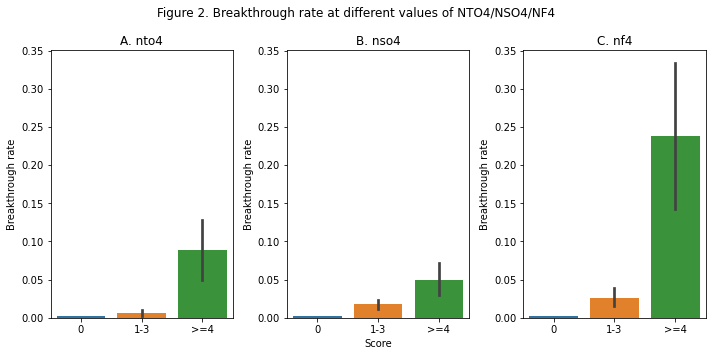

In [8]:
df = load_df('docdb')
eda_1()

In [9]:
bt_rates()

Table 1. Breakthrough rate for subsets with different scores of NTO4, NSO4 and NF4
       nto4  nso4   nf4
score                  
0     0.003 0.002 0.003
1-3   0.006 0.018 0.026
>=4   0.089 0.049 0.238


The values of NTO4, NSO4 and NF4 are not mutually exclusive in a patent, so I explore next if scoring in multiple indicators at once is a good predictor of higher breakthrough rates. To do this I calculate a new feature, *Composite4*, which indicates in how many of these indicators the patent has a positive score (i.e., greater than zero). Hence, this feature takes integer values between 0 and 3.

I also calculated <i>Composite4 score</i> as the sum of NTO4, NSO4 and NF4. Figure 3 below shows the breakthrough rates for these new indicators and suggests that scoring in multiple features is a good predictor of breakthroughs. First, the tallest bar in Panel A shows that patents that score positively (and simultaneously) in NTO4, NSO4 and NF4 have a breakthrough probability equal to 12.5% (41x the baseline, or unconditional probability, of 0.3%). Second, Panel B shows that patents with a composite score equal or greater than 4 have a breakthrough probability of about 5% (16.7x the baseline). Notably, the confidence intervals are significantly smaller than those in Figure 1.



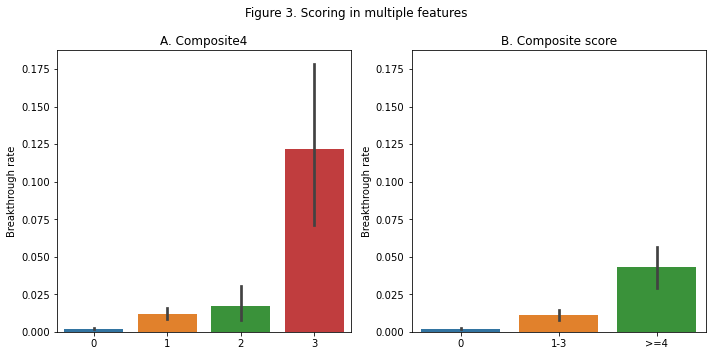

In [10]:
eda_2()

### 4. Supervised learning (i): Logistic classifiers

I begin the (exploratory) supervised learning task by training logistic classifiers on the complete dataset. This allows to compare the overall performance of the baseline and extended models. In a later step I examine the predictive power of the model with the customary validation: a train/test split. 

<b>Preprocessing. </b> Training logistic classifiers requires preprocessing the dataset. Accordingly, non-categorical features were log-transformed and scaled with MinMaxScaler.

<b>Feature engineering. </b> The feature with patents' application years was one-hot encoded into a set of dummies. Each of the novelty features (NSOx, NTOx, NFx) was used to create two additional features: a dummy (which equals one if the focal feature's value is greater than zero) and an IPC-corrected feature (which corrects for the number of IPC classes in a patent, taking into account that patents with more IPC classes are by default more likely to get higher novelty scores).

<b>Hyperparameter tuning. </b> It was performed as a grid search over potential values of lambda, the penalty and the scaler (but not reported here for parsimony). Results indicate the best models are obtained by setting lambda equal to 3, 'l2' as the penalty and MinMaxScaler to scale features.
    
<b>Model results. </b> Table 2 reports the models and their performance/quality indicators. All models include features for the IPC4 technology classes, control variables and existing ex-ante indicators. Model 1 is the baseline and hence does not include the novelty features nor the INPADOC correction. Overall, the performance of the model is rather poor, especially in terms of recall. Recall is 0.17, precision is 0.87 and average precision is 0.29. In other words, the model detects only 17% of the true breakthroughs with a precision of 87% (when the cutoff of for predicting labels is equal to 0.5).
    
Model 2 extends the baseline by including novelty features, while Model 3 includes both novelty features and the INPADOC correction. Both models increase predictive power relative to the baseline. Model 3 increases recall by 105%, precision by 5%, average precision by 88% and the AUC score by 15%. For further comparison, Figure 4 presents the estimated ROC curves and precision-recall curves for each model. Panel B confirms that the INPADOC family correction produces a sensible increase in average precision (the precision-recall curve moves to the right).    

Table 2. Results from logistic classifier models

                         Model 1 Model 2 Model 3
IPC4                        Yes     Yes     Yes
Controls                    Yes     Yes     Yes
Existing ex-ante            Yes     Yes     Yes
Novelty                      No     Yes     Yes
Inpadoc fam. correction      No      No     Yes
Penalty                      l2      l2      l2
Lambda                        3       3       3
Recall (cutoff=0.5)       0.174   0.220   0.357
Precision (cutoff=0.5)    0.872   0.945   0.921
Accuracy                  0.998   0.998   0.995
Average precision         0.297   0.361   0.561
AUC                       0.587   0.610   0.678


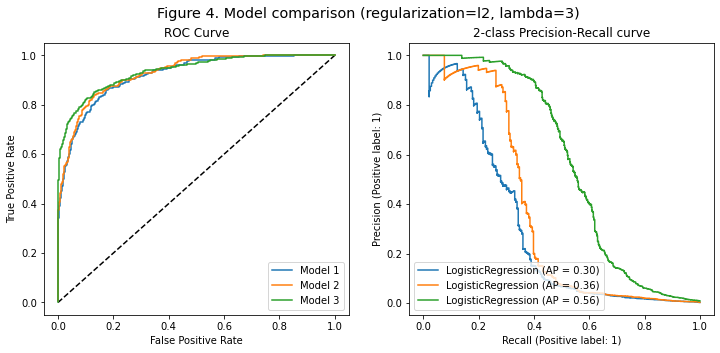

In [11]:
list_ipc4 = [x for x in df.columns if x[:6]=='ipc4__']    
model_features = [list_ipc4, controls+time_dummies, existing_exante, rad_all]
feature_names = ['IPC4','Controls','Existing ex-ante','Novelty']
features_order = [[1,1,1,0],[1,1,1,1]]
outcome = model(['docdb','inpadoc'],
                model_features=model_features,
                features_order=features_order,
                feature_names=feature_names,
                lambda_=3)
print('Table 2. Results from logistic classifier models\n\n',outcome)

<b> Validating Model 3 with a train/test split. </b> After comparing the baseline and extended models, I perform a 70/30 train/test validation test to evaluate the predictive power of Model 3. To avoid data leakage, the scaler is trained on the train set and used to transform the test set afterwards. Table 3 and Figure 5 show the outcomes of the validation step. Results are in line with those shown above and do not raise concerns of over- or underfitting. 

Because the results of this validation test may depend on the way data is split into train and test sets, as a robustness check I performed a 4-fold cross validation on each of the quality indicators. Results are similar to those reported above (available upon request). Additionally, I ran the train/test validation step on the full dataset 100 times using random values for random_state (the parameter that controls how the data is split), calculating performance indicators each time and averaging them out. Results are similar to those reported here (available upon request).

Table 3. Train/test split validation for Model 3

                        Train  Test
IPC4                      Yes   Yes
Controls                  Yes   Yes
Existing ex-ante          Yes   Yes
Novelty                   Yes   Yes
INPADOC fam. correction   Yes   Yes
Recall                  0.312 0.347
Precision               0.890 0.884
Accuracy                0.995 0.995
Avg precision           0.520 0.545
AUC                     0.656 0.673


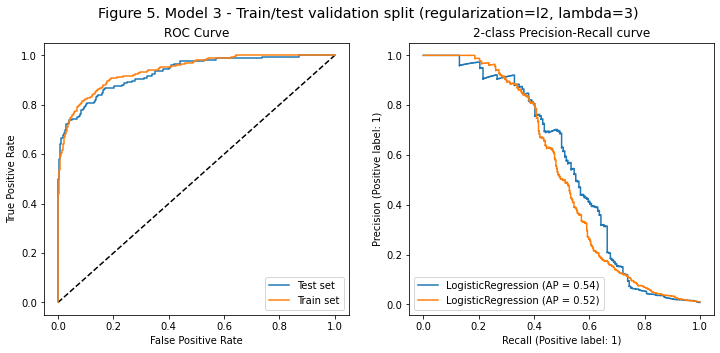

In [12]:
train_test_validation(level='inpadoc', lambda_= 3, penalty='l2')

### 5. Supervised learning (ii): Random forests classifier

In the final step, I reestimate Model 3 using a random forests classifier. RFC are ensemble models which train several sub-models (namely classification trees) using subsets of features and combine them using a voting rule to predict a target. The advantage of RFC over logistic classifiers is that training several models the overall structure becomes quite resilient to overfitting. As before, I performed a 70/30 train/test split as validation, an present the quality indicators in Table 4. 
In the test set, recall has risen to 0.69 and precision is equal to 1. This implies that the RFC is able to detect almost 70% of the true breakthroughs with full precision. Moreover, average precision and AUC have also increased significantly, to 0.87 and 0.85, respectively. The superior performance of the RFC model is confirmed with Figure 6, as the precision-recall curve switches significantly to the right.

As a side check, not reported here for brevity, training a RFC on the baseline model produces some performance gains, but significantly lower to those presented in Table 4. This suggests the best model results not only from the machine learning model chosen and its hyperparameters, but also from feature selection/enginering, and from background knowledge on patent analytics (e.g., on the definitions and implications of patent families).

Table 4. RFC - Quality indicators
 
                         Train  Test
IPC4                      Yes   Yes
Controls                  Yes   Yes
Existing ex-ante          Yes   Yes
Novelty                   Yes   Yes
INPADOC fam. correction   Yes   Yes
Recall                  0.966 0.693
Precision               1.000 1.000
Accuracy                1.000 0.998
Avg precision           1.000 0.872
AUC                     0.983 0.847


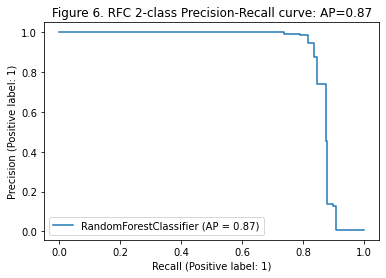

In [13]:
rfc_fitted, X_colnames = rfc_1('inpadoc')

<b>Feature importance. </b> I extracted the most important features from the RFC model trained on the train data and plot them in Figure 7, by decreasing order of importance. Among the top 10 features by importance, 8 are ex-ante novelty indicators, which confirms their contribution to the prediction of breakthroughs. The most important feature is NTO4, with a score of 0.96. This is 4.57 times the score of the most important existing ex-ante feature (shane_ipc6, with a score of 0.21).

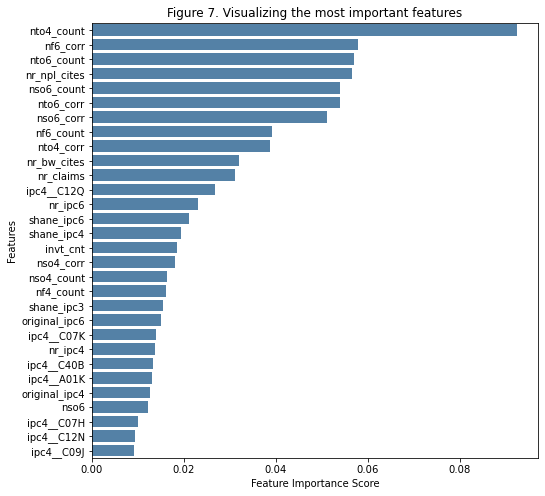

<Figure size 432x288 with 0 Axes>

In [14]:
rfc_2(rfc_fitted, X_colnames)

### 6. Conclusion

The goal of this notebook was to present machine learning models that can help with the early prediction of breakthrough patents (i.e., with significant technological impact and great commercial potential) relying only on data available at the time of the patent grant. The best results are obtained using a random forests classifier with the customary hyperparameter tuning, but also with a significant contribution that comes from adding new features, feature engineering and background knowledge on patent analytics.

Relative to the baseline model, the RFC improves recall and average precision 405% and 93%, respectively. In a 70/30 train/test validation analysis the RFC model produces recall and precision scores of 0.69 and 1, respectively. This implies that the model identifies 69% of the breakthrough biotech patents in the test set with 100% precision. Extensions of this work, currently under way, attempt to improve these scores even further with more advanced feature management (reducing dimensionality, combining features, etc.)

### References

- Arts, S., Appio, F. P., & Van Looy, B. (2013). Inventions shaping technological trajectories: do existing patent indicators provide a comprehensive picture?. Scientometrics, 97(2), 397-419.
- Bakker, J., Verhoeven, D., Zhang, L., & Van Looy, B. (2016). Patent citation indicators: One size fits all?. Scientometrics, 106(1), 187-211.
- Harhoff, D., Scherer, F. M., & Vopel, K. (2003). Citations, family size, opposition and the value of patent rights. Research policy, 32(8), 1343-1363.
- Shane, S. (2001). Technological opportunities and new firm creation. Management science, 47(2), 205-220.
- Trajtenberg, M., Henderson, R., & Jaffe, A. (1997). University versus corporate patents: A window on the basicness of invention. Economics of Innovation and new technology, 5(1), 19-50.
- Verhoeven, D., Bakker, J., & Veugelers, R. (2016). Measuring technological novelty with patent-based indicators. Research Policy, 45(3), 707-723.
